In [1]:
import tide_constituents as tc
import pandas as pd
import numpy as np
import datetime
import tappy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
pd.plotting.register_matplotlib_converters()

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [3]:
def sum_signals(constituents, hours, speed_dict, amp, phase):
    import numpy as np
    import astronomia.calendar as cal


    jd = [cal.cal_to_jd(i.year, i.month, i.day) + cal.hms_to_fday(i.hour, i.minute, i.second) for i in hours]
    hours = np.array(jd).flatten()
    hours = (hours - hours[0]) * 24.0
    total = np.zeros(len(hours), dtype=np.float64)

    deg2rad = np.pi/180.0
    for i in constituents:
        total = total + amp[i] * speed_dict[i]['FF'] * np.cos(speed_dict[i]['speed'] * hours - (phase[i] - speed_dict[i]['VAU']) * deg2rad)
    return total

In [4]:
start = '20160301'
end = '20160314'
interval = 5

In [20]:
start = pd.to_datetime(start)
end = pd.to_datetime(end)
d = start
w, t, p, r = [], [], [], []

while d < end:
    start_ = d
    end_ = start_ + pd.DateOffset(interval)
    end_ = end_ if end_ < end else end
    water_level, tide = tc.get_tides(start_.strftime('%Y%m%d'),
                                     end_.strftime('%Y%m%d'),
                                     -88.2, 30.4)
    prediction = 0.0 if 'Z0' not in list(tide.speed_dict.keys()) else tide.speed_dict['Z0']
    prediction += sum_signals(tide.key_list, tide.dates, tide.speed_dict, tide.r, tide.phase)
    residual = water_level.water_level.values - prediction
    w.append(water_level)
    t.append(tide)
    p.append(prediction)
    r.append(residual)
    d = end_

In [26]:
water_level = pd.concat(w)
water_level['prediction'] = np.hstack(p)
water_level['residual'] = np.hstack(r)
#water_level = water_level[['water_level', 'prediction', 'residual']]
#water_level.columns = ['observation', 'prediction', 'residual']
water_level = water_level[['water_level', 'prediction']]
water_level.columns = ['observation', 'prediction']

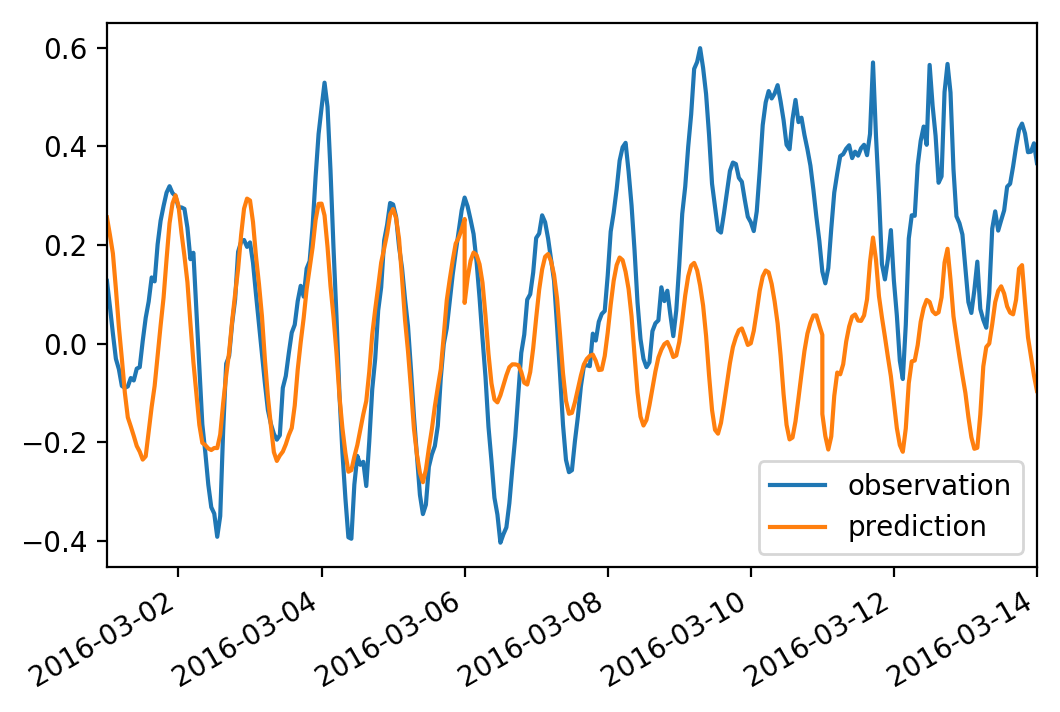

In [27]:
ax = water_level.plot()
ax.set_xlabel('');